In [3]:
# Import necessary library
import pandas as pd 
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style="whitegrid")

In [4]:
# Get user sp auth read library
scope = "user-library-read"
auth_manager = SpotifyOAuth(scope = scope)
sp_user = spotipy.Spotify(auth_manager=auth_manager)

In [5]:
# Get user like songs by artist_id
def get_tracks_by_artists():
    track_list = []
    artist_id_list = []
    for offset_num in range(0,10000,50):
        current_saved_tracks = sp_user.current_user_saved_tracks(limit = 50, offset = offset_num)
        if len(current_saved_tracks['items']) == 0:
            break
        else:
            for item in current_saved_tracks['items']:
                track = item['track']
                track_list.append(track['name'])
                artist_id_list.append(track['artists'][0]['id'])
    tracks_artists_id = pd.DataFrame({"track_name":track_list,
                                     "artist_id":artist_id_list},
                                    columns=["track_name","artist_id"])
    return tracks_artists_id

In [6]:
# Get artist name by artist_id
def get_artists_info():
    artist_list = []
    artist_id_list = []
    for offset_num in range(0,10000,50):
        current_saved_tracks = sp_user.current_user_saved_tracks(limit = 50, offset = offset_num)
        if len(current_saved_tracks['items']) == 0:
            break
        else:
            for item in current_saved_tracks['items']:
                track = item['track']
                artist_list.append(track['artists'][0]['name'])
                artist_id_list.append(track['artists'][0]['id'])
    artists_info = pd.DataFrame({"artist_id":artist_id_list,
                                "artist_name":artist_list},
                                columns=["artist_id","artist_name"]).drop_duplicates().reset_index(drop = True)
    return artists_info    

In [7]:
# Get artist genres by artist id 
def get_artists_genres():
    artist_id_list = []
    genres_list = []
    for offset_num in range(0,10000,50):
        current_saved_tracks = sp_user.current_user_saved_tracks(limit = 50, offset = offset_num)
        if len(current_saved_tracks['items']) == 0:
            break
        else:
            for item in current_saved_tracks['items']:
                track = item['track']
                artist_id_list.append(track['artists'][0]['id'])
    unique_artist_id_list = list(set(artist_id_list))
    for artist_id in unique_artist_id_list: 
        genres_list.append(sp_user.artist(artist_id)['genres'])
    artist_id_genres = pd.DataFrame({"artist_id":unique_artist_id_list,
                                    "genres_name":genres_list},
                                   columns = ["artist_id","genres_name"])
    artist_id_genres = artist_id_genres.explode("genres_name").reset_index(drop=True)
    return artist_id_genres

In [8]:
# Get songs information
def get_tracks_info():
   track_id_list = []
   for offset_num in range(0,10000,50):
      current_saved_tracks = sp_user.current_user_saved_tracks(limit = 50, offset = offset_num)
      if len(current_saved_tracks['items']) == 0:
         break
      else:
         for item in current_saved_tracks['items']:
            track = item['track']
            track_id_list.append(track['id'])
   track_info = ['id','danceability', 'energy', 'loudness', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
   track_information = pd.DataFrame(columns=track_info)
   for song_id in track_id_list:
      value = sp_user.audio_features(song_id)[0]
      value_df = pd.DataFrame(value,index=[0])[track_info]
      track_information = pd.concat([track_information,value_df],ignore_index = True)
   return track_information
    

In [9]:
# Get the data
# I set sleep time 5 second after each called just to make sure it won't be timeout by running so many times
tracks_artists = get_tracks_by_artists()
time.sleep(5)
artist_genres = get_artists_genres()
time.sleep(5)
artist_info = get_artists_info()
time.sleep(5)
track_info = get_tracks_info()

In [10]:
# Get tracks by artist name
tracks_artists_name = tracks_artists.merge(artist_info, on = 'artist_id',how = 'left')

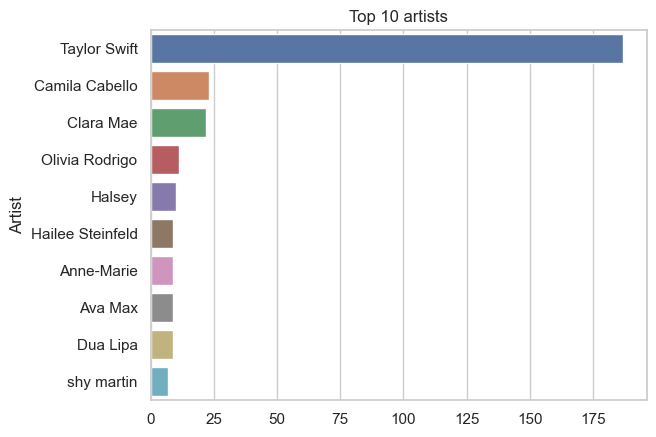

In [11]:
# Top 10 artists 
tracks_count_by_artist = tracks_artists_name['artist_name'].value_counts().reset_index()

sns.barplot(x = "count", y = "artist_name", data = tracks_count_by_artist.head(10))

plt.title("Top 10 artists")
plt.xlabel(None)
plt.ylabel("Artist")
plt.show()

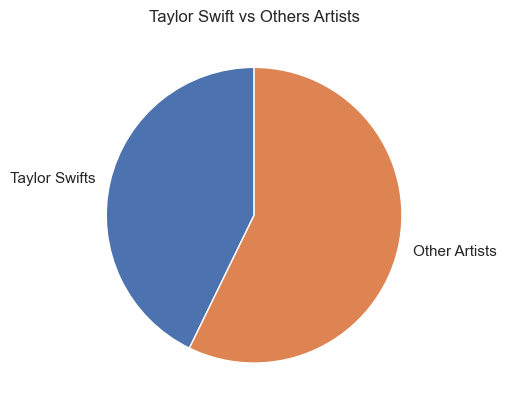

In [12]:
# Taylor Swift vs the others
taylor_songs = len(tracks_artists_name[tracks_artists_name['artist_name'] == "Taylor Swift"])
other_songs = len(tracks_artists_name[tracks_artists_name['artist_name'] != "Taylor Swift"])

plt.pie(x = [taylor_songs,other_songs], labels = ["Taylor Swifts","Other Artists"],startangle = 90)
plt.title("Taylor Swift vs Others Artists")
plt.show()

It's no suprise that Taylor Swift contributed the most song on my liked song. I'm a Swifties to be honest. 

Before seeing what genres I listen to the most, I sure it'll be Pop 😁.

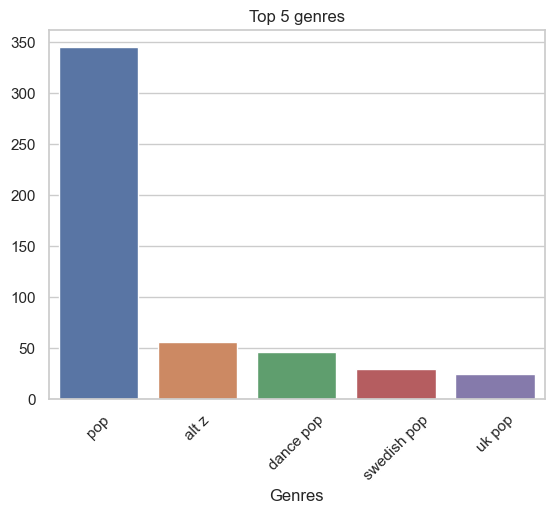

In [13]:
# Top 5 genres
tracks_genres = tracks_artists.merge(artist_genres, on = 'artist_id', how = 'left')

tracks_count_by_genres = tracks_genres.value_counts('genres_name').reset_index()

sns.barplot(x = "genres_name", y = "count", data = tracks_count_by_genres.head(5))

plt.title("Top 5 genres")

plt.xlabel("Genres")
plt.ylabel(None)

plt.xticks(rotation = 45)

plt.show()

My guest was right, most of my songs was from Taylor Swift, so it's easily understand that my top 1 genre should be pop.

Before analyse my song listening, let's have an understanding about each atribute first.

- Danceability : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- Energy : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- Instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- Acousticness : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

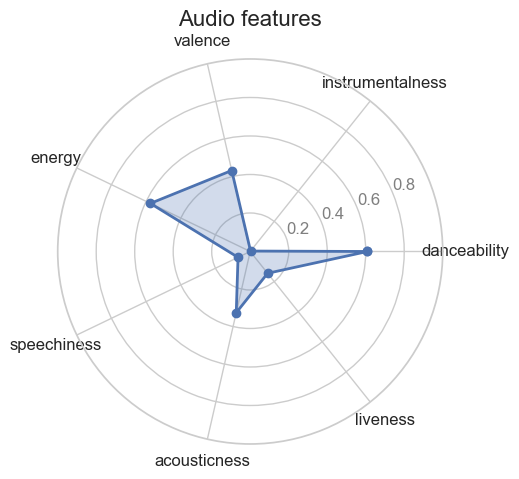

In [14]:
# Audio features
labels = ['danceability', 'instrumentalness', 'valence',
          'energy','speechiness','acousticness',  'liveness']

data = track_info[labels].mean().tolist()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
data = np.concatenate((data,[data[0]]))
angles = np.concatenate((angles,[angles[0]]))

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})

ax.plot(angles, data, 'o-', linewidth=2)  # 'o-' specifies marker and line style
ax.fill(angles, data, alpha=0.25)  # Fill the area enclosed by the lines with color

plt.yticks([0.2 , 0.4 , 0.6 , 0.8], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.set_xticks(angles[:-1])  # Set the positions of the radial ticks
ax.set_xticklabels(labels, fontsize=12)  # Set the labels for the radial ticks
ax.grid(True)  # Display gridlines

ax.set_title('Audio features', fontsize=16)
plt.show()

I didn't know that almost all of my songs are full vocals. The song that has high danceability and is energetic is also my favourite, funny that I never dance while listening to my playlist 😂. I didn't listen to a live song, talk show or audio book too; I can't focus on listening to something for too long. However, sometimes I am still chilling with acoustic songs, everyone needs a rest right 🛌.

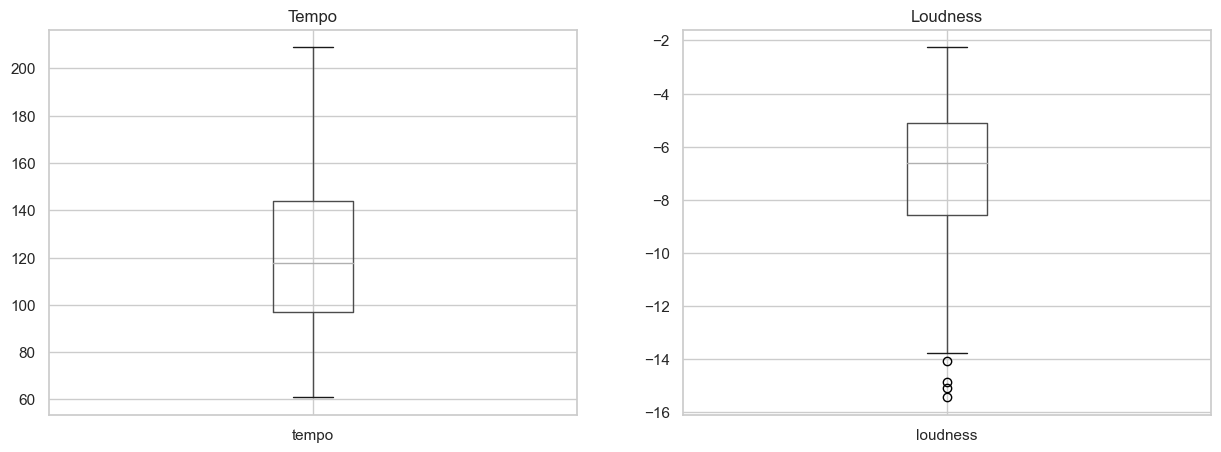

In [17]:
#Tempo and loudness
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

track_info.boxplot(column='tempo',ax=ax1)
ax1.set_title('Tempo')
track_info.boxplot(column='loudness',ax=ax2)
ax2.set_title('Loudness')

plt.show()

My tempo and loudness range are quite high, to be honest, sometimes I like listening to loud and fast tempos and the next moment I can listen to soft and slow tempos. Does it strange? 🤔